In [1]:
#Importing the Libraries
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
import math
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import plot_model


In [2]:
TRAIN_DATA_PATH = 'NASA/KC3.csv'

data = pd.read_csv(TRAIN_DATA_PATH)
nameOfHeadersWithLable = data.columns.values
display(data)

,LOC_BLA0K,BRA0CH_COU0T,CALL_PAIRS,LOC_CODE_A0D_COMME0T,LOC_COMME0TS,CO0DITIO0_COU0T,C1CLOMATIC_COMPLEXIT1,C1CLOMATIC_DE0SIT1,DECISIO0_COU0T,DECISIO0_DE0SIT1,...,0ODE_COU0T,0ORMALIZED_C1LOMATIC_COMPLEXIT1,0UM_OPERA0DS,0UM_OPERATORS,0UM_U0IQUE_OPERA0DS,0UM_U0IQUE_OPERATORS,0UMBER_OF_LI0ES,PERCE0T_COMME0TS,LOC_TOTAL,Defective
0,22,43,20,3,11,38,26,0.20,18,2.11,...,108,0.16,255,411,91,30,166,9.86,131,0
1,2,11,10,0,1,12,7,0.20,6,2.00,...,33,0.18,60,105,35,20,39,2.78,35,0
2,0,7,2,0,0,4,5,0.22,2,2.00,...,16,0.21,31,58,14,13,24,0.00,23,0
3,5,18,15,0,0,26,10,0.19,12,2.17,...,57,0.17,137,216,53,21,59,0.00,52,0
4,1,13,10,0,0,24,7,0.32,12,2.00,...,35,0.28,55,98,30,17,25,0.00,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,19,24,17,2,12,16,15,0.17,8,2.00,...,70,0.12,189,306,70,26,122,14.00,88,1
196,1,8,5,0,1,8,5,0.24,4,2.00,...,19,0.21,18,48,11,13,24,4.55,21,0
197,4,9,5,0,1,14,5,0.31,6,2.33,...,23,0.22,26,53,13,17,23,5.88,16,0
198,2,3,2,0,0,4,2,0.22,2,2.00,...,7,0.15,11,22,7,11,13,0.00,9,0


In [3]:
# transform data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
reduced_df = pd.DataFrame(scaled, columns=nameOfHeadersWithLable)
reduced_df.to_csv('FirstlyScaledData.csv')
# display(reduced_df)
# display(scaled)

data2 = pd.read_csv('FirstlyScaledData.csv')
y = data2.Defective
X = data2.drop('Defective', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

nameOfHeaders = X_train.columns.values

In [4]:
# AutoEncoder Model Preparation
n_inputs = X.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs*2)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(encoder)
# define decoder, level 1
decoder = Dense(n_inputs)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs*2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)


In [5]:
# output layer
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
model = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 dense (Dense)               (None, 80)                3280      
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 40)                3240      
                                                                 
 batch_normalization_1 (Batc  (None, 40)               160       
 hNormalization)                                             

In [7]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# plot the autoencoder
plot_model(model, 'autoencoder_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=2, validation_data=(X_test,y_test))
# # plot loss
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/50
10/10 - 1s - loss: 0.6095 - accuracy: 0.1750 - val_loss: 0.8327 - val_accuracy: 0.7250 - 1s/epoch - 112ms/step
Epoch 2/50
10/10 - 0s - loss: 0.3100 - accuracy: 0.2125 - val_loss: 0.4908 - val_accuracy: 0.0500 - 61ms/epoch - 6ms/step
Epoch 3/50
10/10 - 0s - loss: 0.2001 - accuracy: 0.3313 - val_loss: 0.3149 - val_accuracy: 0.0000e+00 - 50ms/epoch - 5ms/step
Epoch 4/50
10/10 - 0s - loss: 0.1542 - accuracy: 0.2500 - val_loss: 0.2957 - val_accuracy: 0.0000e+00 - 47ms/epoch - 5ms/step
Epoch 5/50
10/10 - 0s - loss: 0.1365 - accuracy: 0.1125 - val_loss: 0.2828 - val_accuracy: 0.0000e+00 - 45ms/epoch - 4ms/step
Epoch 6/50
10/10 - 0s - loss: 0.1303 - accuracy: 0.0125 - val_loss: 0.2616 - val_accuracy: 0.0000e+00 - 45ms/epoch - 4ms/step
Epoch 7/50
10/10 - 0s - loss: 0.1274 - accuracy: 0.0063 - val_loss: 0.2252 - val_accuracy:

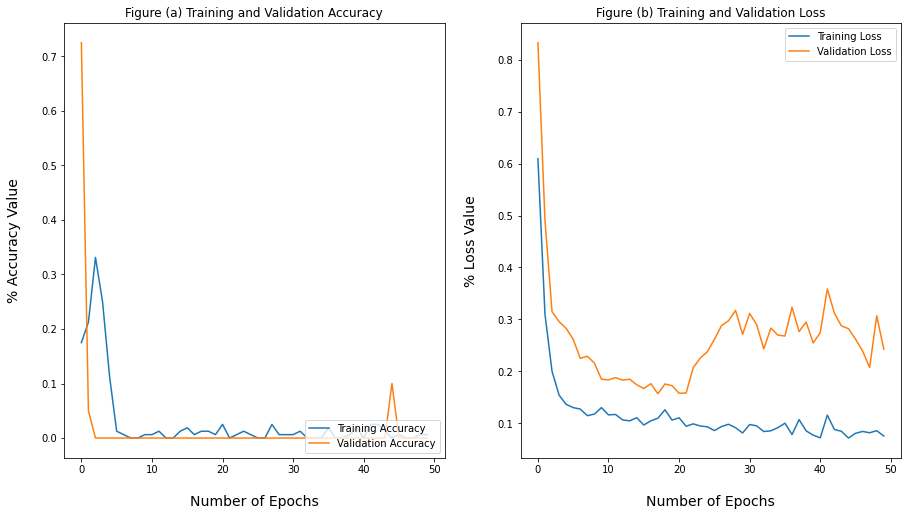

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.xlabel('Number of Epochs', fontsize=14, labelpad=20)
plt.ylabel('% Accuracy Value', fontsize=14, labelpad=20)
plt.legend(loc='lower right')
plt.title('Figure (a) Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.xlabel('Number of Epochs', fontsize=14, labelpad=20)
plt.ylabel('% Loss Value', fontsize=14, labelpad=20)
plt.legend(loc='upper right')
plt.title('Figure (b) Training and Validation Loss')
plt.show()

# define an encoder model (without the decoder)
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
# save the encoder to file
encoder.save('encoder.h5')

In [9]:
#Building a Base Model to compare the performance after compressing the data using Encoder model.

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define model
model = RandomForestClassifier()
# fit model on training set
model.fit(X_train, y_train)
# make prediction on test set
yhat = model.predict(X_test)
# calculate accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.825


In [10]:
#Compressing the input data using Encoder Model and fitting it on the Logistic Regression model.
# load the model from file
encoder = load_model('encoder.h5')

encoder.compile(optimizer='adam', loss='mse')

# encode the train data
X_train_encode = encoder.predict(X_train)

# encode the test data
X_test_encode = encoder.predict(X_test)

# nameOfHeaders = X_train.columns.values
# reduced_df = pd.DataFrame(encoder.predict(x_test), columns=nameOfHeaders)

# reduced_df.to_csv('PredictedJM1OnTestData.csv')


# define the model
random_forest = RandomForestClassifier(max_depth=50)
# fit the model on the training set
random_forest.fit(X_train_encode, y_train)
# make predictions on the test set
yhat = random_forest.predict(X_test_encode)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

2/2 [==============================] - 0s 16ms/step
0.8


In [11]:
print('Optimal number of features: {}'.format(random_forest.n_features_))

Optimal number of features: 20


C:\Users\Zbook\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


array([0.0527517 , 0.01989864, 0.06774459, 0.03938881, 0.04676192,
       0.04949463, 0.0510194 , 0.07265599, 0.03084881, 0.04537824,
       0.04913713, 0.04431366, 0.04364602, 0.03832488, 0.05051785,
       0.03619857, 0.04694042, 0.03956777, 0.07892834, 0.09648263])

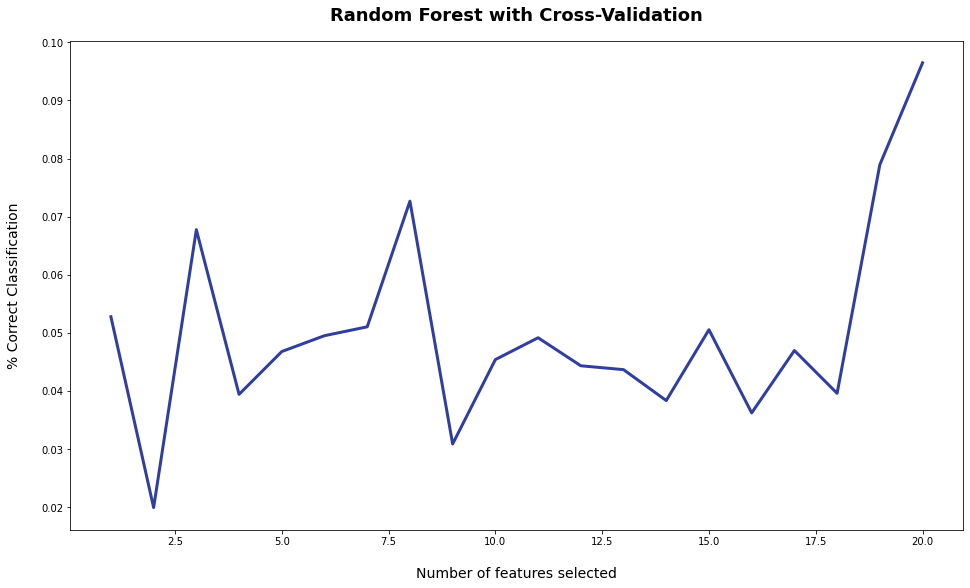

In [12]:
display(random_forest.feature_importances_)
plt.figure(figsize=(16, 9))
plt.title('Random Forest with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(random_forest.feature_importances_) + 1), random_forest.feature_importances_, color='#303F9F', linewidth=3)

plt.show()